In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
import networkx as nx

In [2]:
libpath = os.path.abspath('..')
if libpath not in sys.path:
    sys.path.append(libpath)

In [3]:
from qubitrbm.qaoa import QAOA
from qubitrbm.optimize import Optimizer
from qubitrbm.rbm import RBM
from qubitrbm.utils import exact_fidelity

## The setup

Define a graph to run QAOA on:

In [4]:
G = nx.random_regular_graph(d=3, n=12, seed=12345)

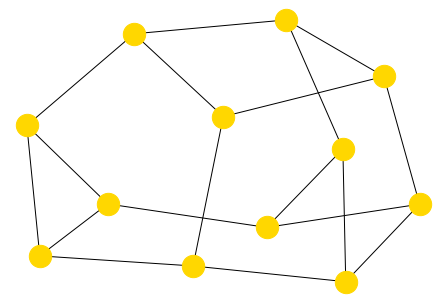

In [5]:
nx.draw_kamada_kawai(G, node_color='gold', node_size=500)

For $p>1$, provided we have a small graph, we can find optimal angles exactly:

In [6]:
qaoa = QAOA(G, p=2)

In [7]:
%%time
angles, costs = qaoa.optimize(init=[np.pi/8, np.pi/8, 0, 0], tol=1e-4)

Iteration  21 | Cost = -4.8549
Iteration  46 | Cost = -7.2894
Iteration  73 | Cost = -7.5796
Iteration 100 | Cost = -7.7953
Iteration 127 | Cost = -8.0803
Iteration 154 | Cost = -8.4390
Iteration 181 | Cost = -8.7488
Iteration 208 | Cost = -8.8919
Iteration 235 | Cost = -8.9341
Iteration 262 | Cost = -8.9437
Iteration 289 | Cost = -8.9456
CPU times: user 1min 52s, sys: 299 ms, total: 1min 52s
Wall time: 1min 54s


Text(0, 0.5, '$\\langle \\mathcal{C} \\rangle $')

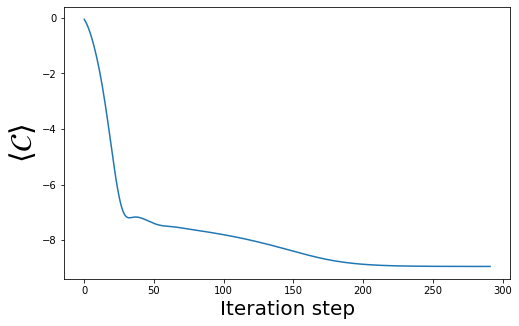

In [8]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(costs)
ax.set_xlabel('Iteration step', fontsize=20)
ax.set_ylabel(r'$\langle \mathcal{C} \rangle $', fontsize=30)

In [9]:
gammas, betas = np.split(angles, 2)

In [10]:
gammas[0] # \gamma _1

0.23917160615017577

In [11]:
gammas[1] # \gamma _2

0.4390927438019701

In [12]:
betas[0] # \beta _1

-0.5325052203000568

In [13]:
betas[1] # \beta _2

-0.28623640252096283

Initialize an RBM ansatz with $N=12$ visible units, the same number as the underlying graph

In [14]:
logpsi = RBM(12)

Exactly apply $U_C (\gamma _1) = \exp \left( -i \gamma _1 \sum _{\langle i, j \rangle } Z_i Z_j \right)$

In [15]:
logpsi.UC(G, gamma=gammas[0], mask=False)

The process introduced a number of hidden units $n_h$ that's equal to the number of edges in the graph. (Plus 1 that was there by default when we initialized the RBM.)

We can look at the numbers:

In [16]:
logpsi.nv, logpsi.nh

(12, 19)

In [17]:
logpsi.alpha # = logpsi.nh / logpsi.nv

1.5833333333333333

## The first optimization

Now, initialize the optimizer and approximately apply $U_B (\beta _1) = \exp \left( -i \beta _1 \sum _i X_i \right)$

In [18]:
optim = Optimizer(logpsi, n_steps=800, n_chains=4, warmup=800, step=12)

In [19]:
%%time

for n in range(len(G)):
    params, history = optim.sr_rx(n=n, beta=betas[0], resample_phi=3, verbose=True)
    optim.machine.params = params
    
    print(f'Done with qubit #{n+1}, reached fidelity {history[-1]}')

Iteration   18 | Fidelity = 0.9964 | lr = 0.100 | Diff mean fidelity = 0.0123916
Done with qubit #1, reached fidelity 0.998000953329977
Done with qubit #2, reached fidelity 1.0000834298426802
Done with qubit #3, reached fidelity 0.9983069316878648
Done with qubit #4, reached fidelity 0.9994458140095546
Done with qubit #5, reached fidelity 0.9979306720701697
Done with qubit #6, reached fidelity 0.9987689536076918
Done with qubit #7, reached fidelity 0.9976420533777627
Done with qubit #8, reached fidelity 0.9954888230057533
Done with qubit #9, reached fidelity 0.9972377891205507
Done with qubit #10, reached fidelity 0.9940960176411124
Done with qubit #11, reached fidelity 0.9961101710344429
Done with qubit #12, reached fidelity 0.9973385115940105
CPU times: user 2min 55s, sys: 10.3 s, total: 3min 6s
Wall time: 1min 51s


In [20]:
logpsi.params = params

It's a good check to compare exact fidelities at this point:

In [21]:
psi_exact = QAOA(G, p=1).simulate(gammas[0], betas[0]).final_state_vector
psi_rbm = logpsi.get_state_vector(normalized=True)

In [22]:
exact_fidelity(psi_exact, psi_rbm)

0.9729183386723347

Next, apply $U_C (\gamma _2) = \exp \left( -i \gamma _2 \sum _{\langle i, j \rangle } Z_i Z_j \right)$

In [23]:
logpsi.UC(G, gamma=gammas[1], mask=False)

However, this doubled the number of hidden units:

In [24]:
logpsi.alpha

3.0833333333333335

## The compression step

We can keep the number of hidden units under control as we go to higher values of $p$ by  performing a compression step, as described in the paper.

Essentially, we define a smaller RBM with `RBM.alpha = 1.5` (the previous value or any we choose to compress to). Then, we optimize parameters of the new RBM to describe the same quantum state as the larger one, obtaining a compressed representaion of

$$  \vert \psi \rangle = U_C (\gamma _2) \; U_B (\beta _1) \; U_C(\gamma _1) \; \vert + \rangle  $$

A heuristically good choice for initial RBM parameters are those values that exactly describe the following quantum state:

$$ \vert \psi _\text{init} \rangle = U_C (\gamma_1 + \gamma _2) \; \vert + \rangle  $$

In [25]:
aux = RBM(len(G))
aux.UC(G, gammas[0] + gammas[1], mask=False)
init_params = aux.params

Now, perform the compression:

In [26]:
%%time
logpsi, history = optim.sr_compress(init=init_params, resample_phi=2, verbose=True)

Iteration   35 | Fidelity = 0.8508 | lr = 0.100 | Diff mean fidelity = 0.1403030
Iteration   68 | Fidelity = 0.9974 | lr = 0.100 | Diff mean fidelity = 0.0013522
CPU times: user 33.8 s, sys: 2.07 s, total: 35.9 s
Wall time: 20.8 s


Let's plot the fidelity as a function of compression optimizer step:

Text(0, 0.5, 'Fidelity')

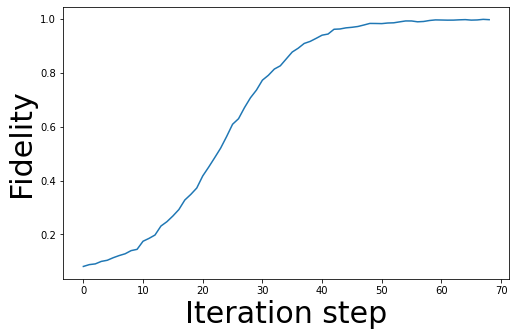

In [27]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(history)
ax.set_xlabel('Iteration step', fontsize=30)
ax.set_ylabel('Fidelity', fontsize=30)

Estimated fidelity reached:

In [28]:
history[-1]

0.9961391724299322

In [29]:
logpsi.alpha

1.5833333333333333

Finally, we can apply $U_B (\beta _2) = \exp \left( -i \beta _2 \sum _i X_i \right)$

In [30]:
optim.machine = logpsi

## The second optimization

In [31]:
%%time

for n in range(len(G)):
    params, history = optim.sr_rx(n=n, beta=betas[1], resample_phi=3, verbose=True)
    optim.machine.params = params
    
    print(f'Done with qubit #{n+1}, reached fidelity {history[-1]}')

Done with qubit #1, reached fidelity 0.9962853878013973
Done with qubit #2, reached fidelity 0.9972587246987061
Done with qubit #3, reached fidelity 0.994852681426915
Done with qubit #4, reached fidelity 0.9971943411091961
Done with qubit #5, reached fidelity 0.9980061336363407
Done with qubit #6, reached fidelity 0.9928338129169417
Done with qubit #7, reached fidelity 0.9933036379803084
Done with qubit #8, reached fidelity 0.9953173854642718
Done with qubit #9, reached fidelity 0.9910975365038862
Done with qubit #10, reached fidelity 0.9890308475706374
Done with qubit #11, reached fidelity 0.9957064458056526
Done with qubit #12, reached fidelity 0.9857012438864056
CPU times: user 2min 31s, sys: 8.95 s, total: 2min 40s
Wall time: 1min 35s


And, compare the final output fidelity at $p=2$:

In [32]:
logpsi.params = params 

In [33]:
psi_exact = QAOA(G, p=2).simulate(gammas, betas).final_state_vector
psi_rbm = logpsi.get_state_vector(normalized=True)

In [34]:
exact_fidelity(psi_exact, psi_rbm)

0.9361896582811029